In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.collab import *
from fastai.tabular import *
from mpl_toolkits.mplot3d import Axes3D

*Download the dataset*

In [5]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/apzl/.fastai/data/movie_lens_sample')

In [6]:
ratings = pd.read_csv(path/"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


*Train model*

In [7]:
np.random.seed(42)
data = CollabDataBunch.from_df(ratings)

In [8]:
y_range = [0, 5.5]

In [9]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

epoch,train_loss,valid_loss,time
0,1.847908,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


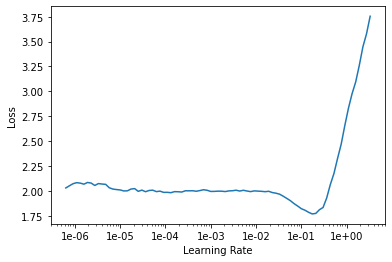

In [10]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(3, 1e-01)

epoch,train_loss,valid_loss,time
0,1.900063,3.436024,00:00
1,3.555627,3.791527,00:00
2,3.359991,3.547766,00:00


## Movielens 100k

In [11]:
path = Config.data_path()/'ml-100k'
path

PosixPath('/home/apzl/.fastai/data/ml-100k')

In [12]:
user, item, title = 'userId', 'movieId', 'title'

In [13]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [20]:
len(ratings)

100000

In [14]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.tail()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.tail()

,userId,movieId,rating,timestamp,title
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."
99999,655,1641,3,887427810,Dadetown (1995)


In [16]:
data  = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [17]:
data.show_batch()

userId,title,target
146,Contact (1997),4.0
70,Stand by Me (1986),4.0
624,Desperate Measures (1998),3.0
788,"Specialist, The (1994)",3.0
716,Raising Arizona (1987),4.0


In [18]:
y_range = [0, 5.5]

In [20]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-01)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


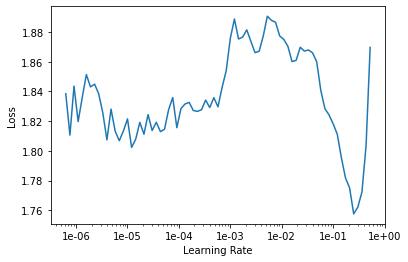

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end=15)


In [22]:
learn.fit_one_cycle(5, 1e-01)


epoch,train_loss,valid_loss,time
0,2.378654,2.285828,00:17
1,2.767509,2.730961,00:24
2,1.950653,1.926032,00:23
3,1.081984,1.084477,00:25
4,0.803246,0.869581,00:23


In [23]:
learn.save('dotprod')

In [24]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [39]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[16:32]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))

Real	Pred	Difference
5.0	4.2	-0.8
5.0	3.8	-1.2
3.0	3.7	0.7
2.0	3.4	1.4
4.0	3.3	-0.7
3.0	3.1	0.1
4.0	3.1	-0.9
3.0	3.8	0.8
5.0	4.2	-0.8
3.0	3.4	0.4
1.0	3.1	2.1
4.0	2.7	-1.3
5.0	4.5	-0.5
2.0	3.2	1.2
3.0	3.6	0.6
5.0	4.0	-1.0


In [26]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [27]:
movie_w = learn.weight(top_movies, is_item=True)
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()

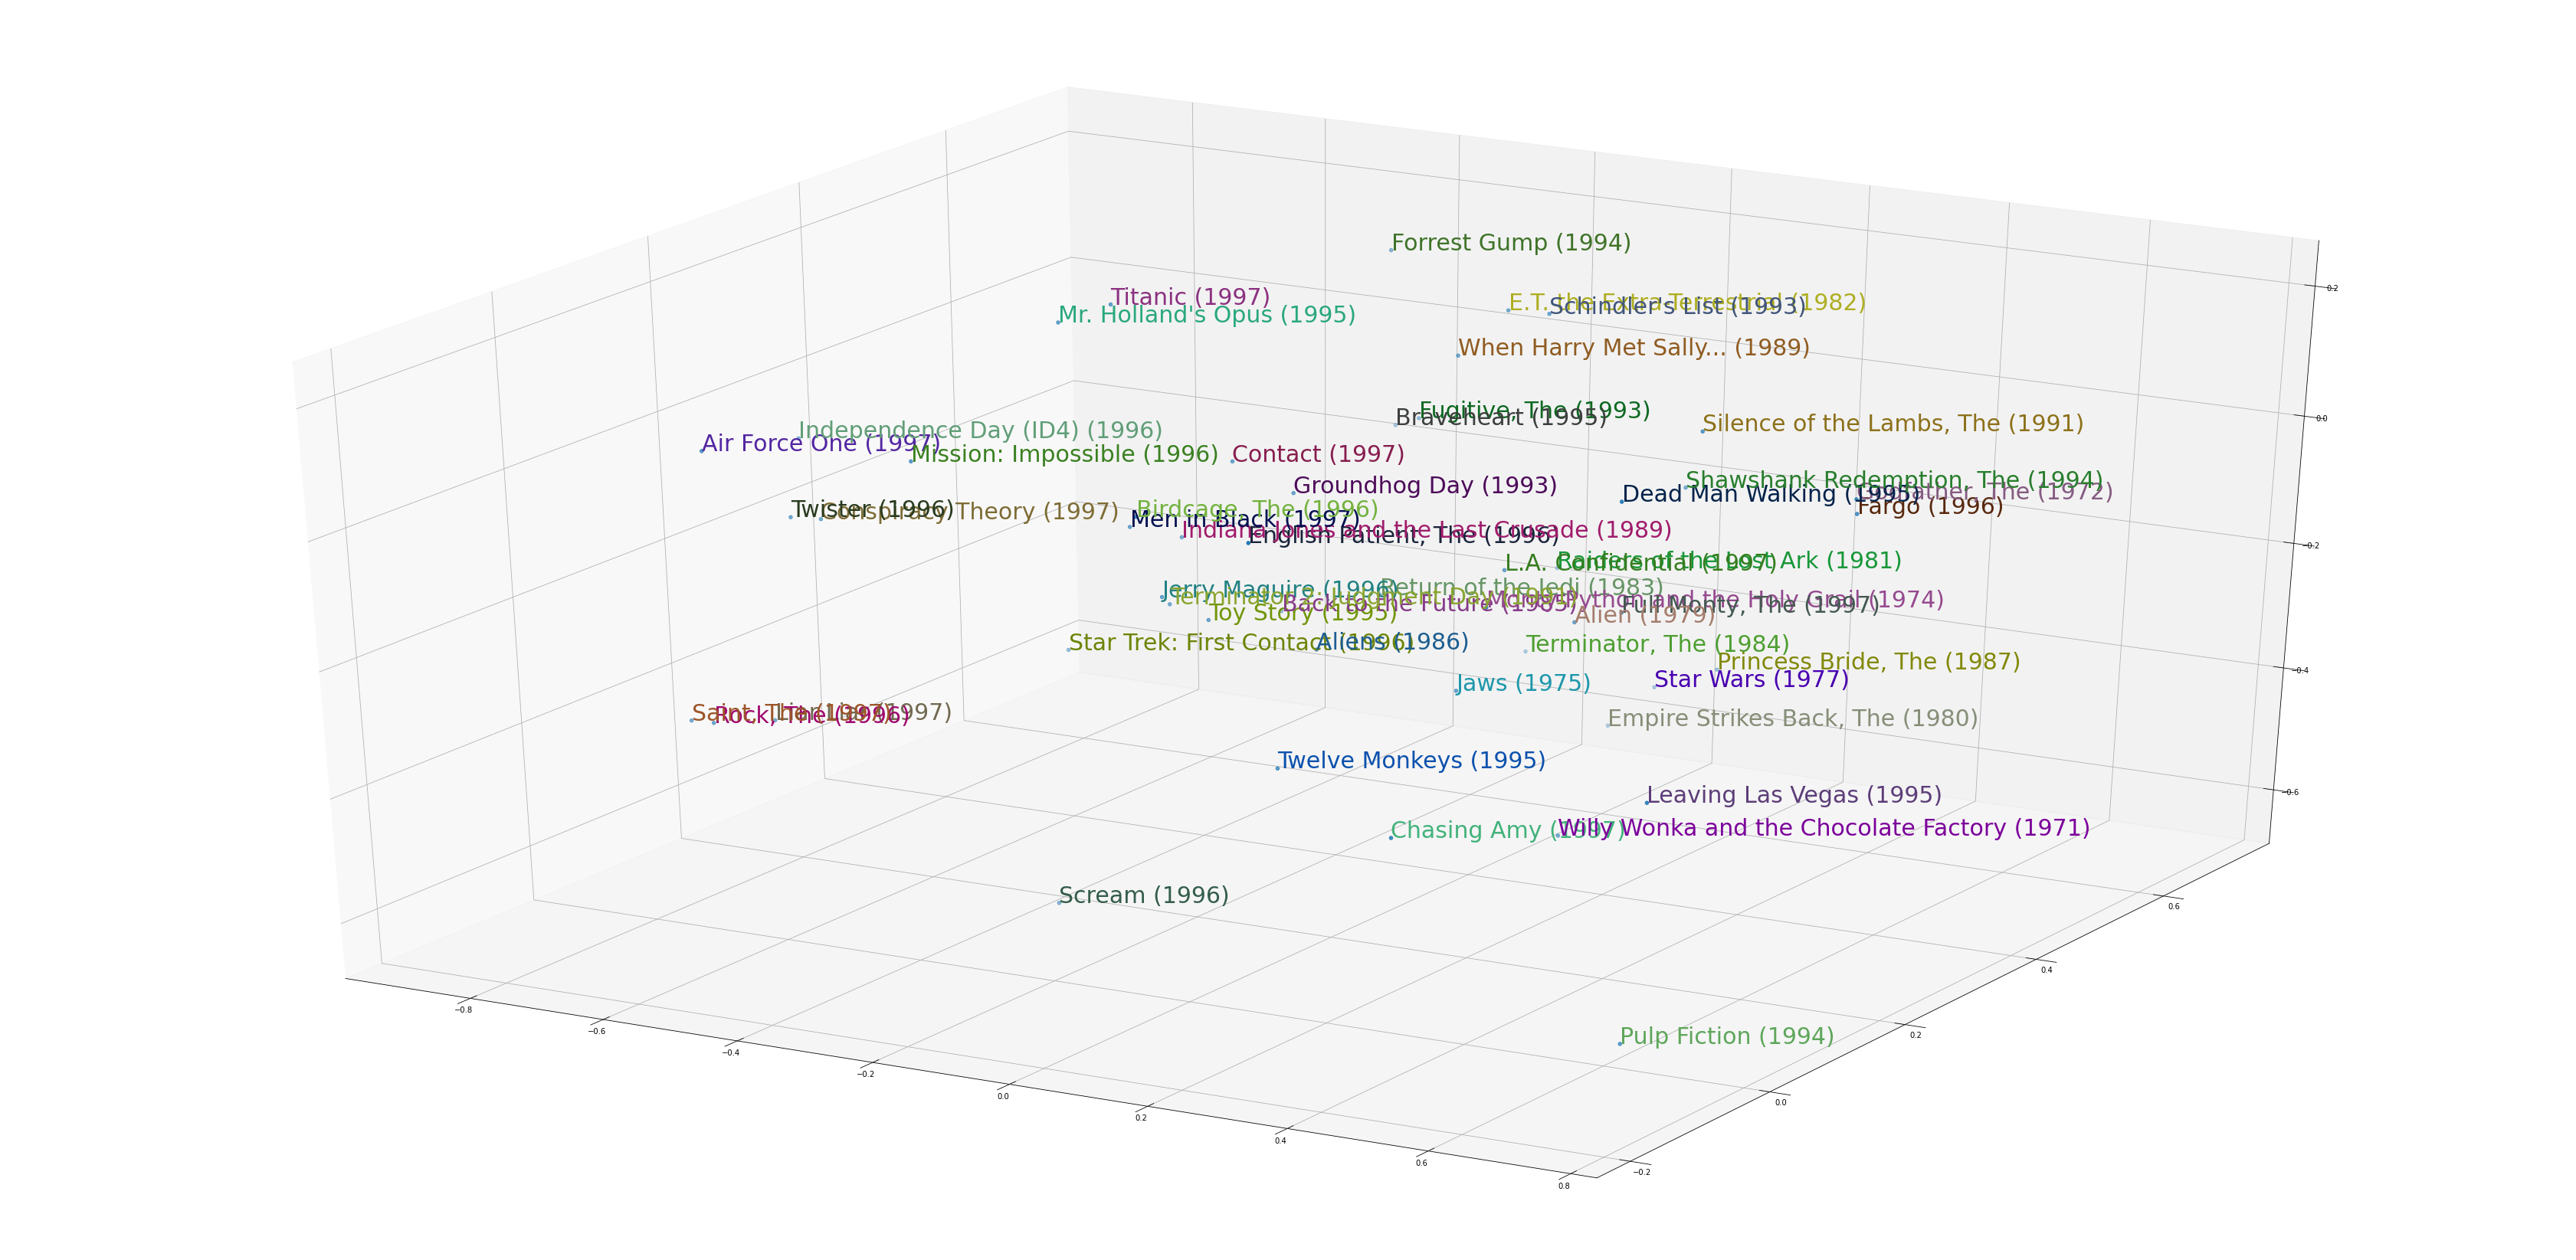

In [50]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
Z = fac2[idxs]
fig = plt.figure(figsize = (60, 30)) 
ax = plt.axes(projection ="3d") 
ax.scatter3D(X, Y, Z)
for i, x, y, z in zip(top_movies[idxs], X, Y, Z):
  ax.text(x, y, z, i, color=np.random.rand(3)*0.7, fontsize=30)
plt.show()